In [2]:
from IPython.display import Image
url = 'Images/maze.png'
Image(url = url, width = 500, height = 500)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook'])

In [42]:
GAMMA = 1 # discounting factor
EPS = 0.5 # learning rate
BETA = 0.5 # exploration-explotation ratio

class ActorCritic():    
    def __init__(self):
        self.R = np.array([0, 0, 0, 0, 5, 2, 0, 0])
        self.state_update = np.array([
            [0,1,2], 
            [1,3,4], 
            [2,5,6], 
            [3,7,7], 
            [4,7,7],
            [5,7,7],
            [6,7,7],
            [7,7,7]])
        
        n_states = len(self.R)
        self.state_value = np.zeros(n_states) # initial guess of the state-value function   
        self.m_policy = np.zeros((n_states, 2)) # initial policy 0.5 prob of moving left or right in every location  
                
    def softmax(self, m, beta = BETA):
        # m = action value vector (left, right)
        # P = Probability vector
        if m.shape[0] > 2:
            P = np.exp(beta * m) / np.sum(np.exp(beta * m), axis = 1).reshape(m.shape[0], 1)
            # reshape to fit the numpy vector operation rules matrix(8x2) / column(8x1) = matrix(8x2)
        else:
            P = np.exp(beta * m) / np.sum(np.exp(beta * m))
        return P

    def choice(self, P):
        if np.random.rand() < P[0]:
            return 1 # left 
        else:
            return 2 # right
        
    def evaluation_update(self):
        # one loop of policy evaluation
        s0 = 0
        for step in ['A', 'B or C', 'Left or Right']:
            move = self.choice(self.softmax(self.m_policy[s0, :]))    
            s1 = self.state_update[s0][move]
            # TDL delta:
            delta = self.R[s1] + GAMMA * self.state_value[s1] - self.state_value[s0]
            self.state_value[s0] += EPS * delta 
            s0 = s1
            
    def improvement_update(self):
        # direct actor: delta_kronecker[0 = left] = [1, 0] so [delta_(left,left), delta_(left,right)]
        delta_kronecker = np.array([[1, 0], [0, 1]])
        # one loop of policy improvement
        for s0 in range(3): # improving every state where an action must be chosen i.e. A(0), B(1), C(2)
            P = self.softmax(self.m_policy[s0, :]) # current policy prob
            move = self.choice(P)    
            s1 = self.state_update[s0][move]
    
            delta = self.R[s1] + GAMMA * self.state_value[s1] - self.state_value[s0]
            self.m_policy[s0] += EPS * (delta_kronecker[move-1] - P) * delta
    def get_state_value(self):
        value = self.state_value.copy()
        return value

In [38]:
rat_maze = ActorCritic()
trials = np.arange(150)
prob = []
state_value_evolution = []
for t in trials:
    prob.append(rat_maze.softmax(rat_maze.m_policy))
    state_value_evolution.append(rat_maze.get_state_value())
    rat_maze.evaluation_update()
    rat_maze.improvement_update()
    
prob = np.array(prob)
state_value_evolution = np.array(state_value_evolution)

In [39]:
def running_avg(x):
    # running average: V_avg = (v1, (v1+v2)/2, (v1+v2+v3)/3, ...)
    return np.cumsum(x) / np.arange(1, len(x)+1)

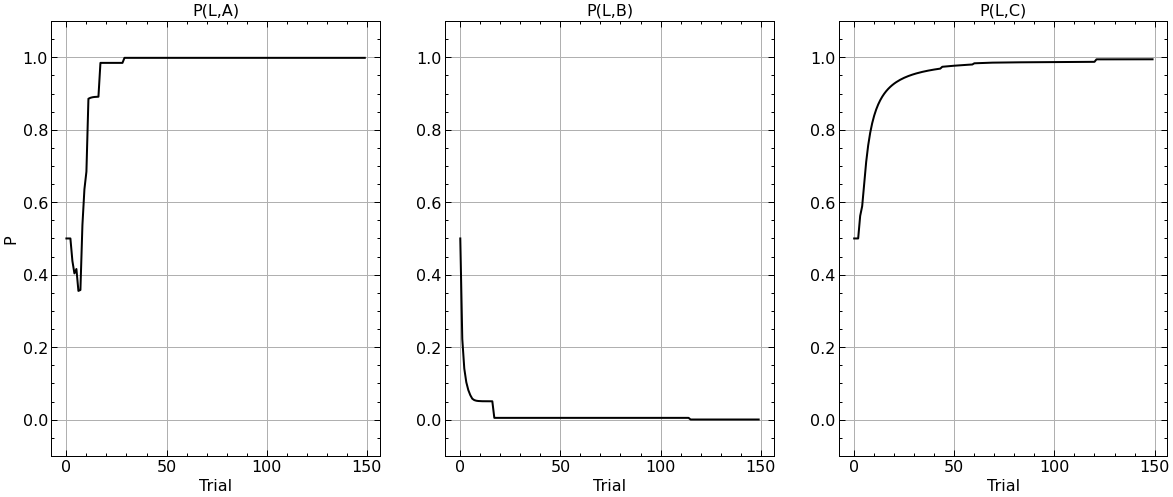

In [40]:
fig, axes = plt.subplots(1, 3, figsize = (20, 8))
title = ['P(L,A)', 'P(L,B)', 'P(L,C)']
for i, ax in enumerate(axes):
    #ax.plot(running_avg(prob[:,i,0]), 'r-')
    ax.plot(prob[:,i,0], 'k-')
    ax.set_title(title[i])
    ax.set_ylim([-0.1, 1.1])
    ax.set_xlabel('Trial')
    ax.grid()
axes[0].set_ylabel('P')
plt.show()

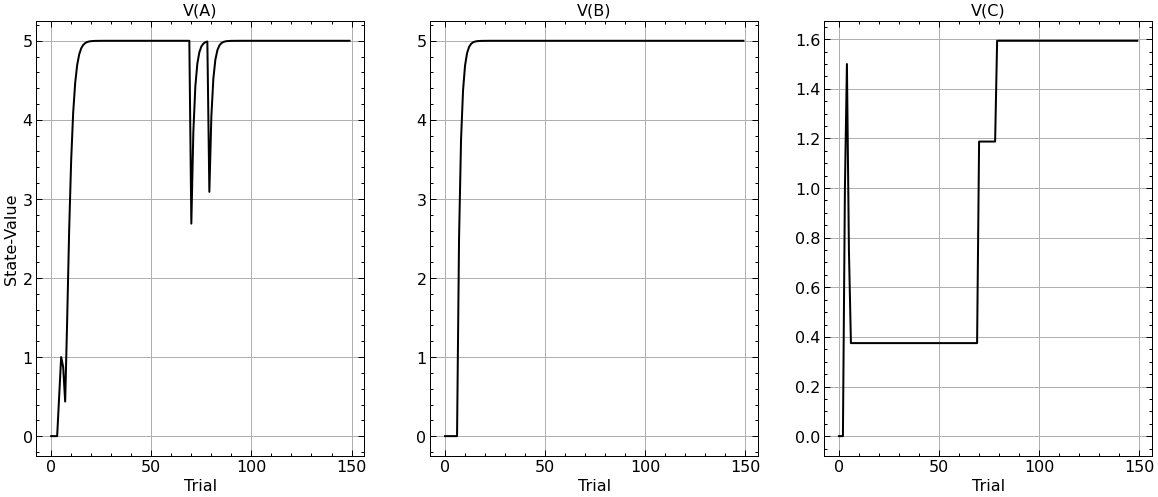

In [41]:
fig, axes = plt.subplots(1, 3, figsize = (20, 8))
title = ['V(A)', 'V(B)', 'V(C)']
for i, ax in enumerate(axes):
    ax.plot(state_value_evolution[:,i], 'k-')
    ax.set_title(title[i])
    ax.set_xlabel('Trial')
    ax.grid()
axes[0].set_ylabel('State-Value')
plt.show()